In [1]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import Plots
using LaTeXStrings

In [2]:
include("utils.jl")
include("system.jl")

get_interferometer (generic function with 1 method)

In [ ]:
Z = NT.load_traj("0.6wr.jld2")

In [ ]:
lines = []
open("0.6wr.txt") do f
    global lines = readlines(f)
end
fidelity = (1 - parse(Float64, lines[2])) * 100

In [ ]:
times = cumsum(vec(Z.dts)) - vec(Z.dts)

In [ ]:
pops = mapslices(x -> abs2.(QC.iso_to_ket(x)), Z.psi_iso; dims=1)
dim = size(pops, 1)

In [ ]:
p1 = Plots.plot(times, pops', xlim=(0.0, 0.6*2pi), ylim=(0., 1.), label=reshape(0:dim-1,1,dim), legend=:outertopright)
Plots.vline!(p1, [times[end]], color=:grey, label=nothing)
Plots.xlabel!(p1, L"t \ [\omega_r^{-1}]")
Plots.ylabel!(p1, "Populations")
Plots.title!(p1, "Lalala")
p2 = Plots.plot(times, Z.phi', xlim=(0.0, 0.6*2pi), ylim=(-pi, pi), label=L"\varphi(t)", legend=:outertopright)
Plots.vline!(p2, [times[end]], color=:grey, label=nothing)
Plots.xlabel!(p2, L"t \ [\omega_r^{-1}]")
Plots.ylabel!(p2, "Amplitude")
p = Plots.plot(p1, p2, size=(800, 500); layout=Plots.@layout [a;b])

In [ ]:
dir = "interferometer/split_bloch910_time_study/"

In [ ]:
durations_wr = round.(0.8:-0.01:0.5; digits=2)
duration_max = durations_wr[1]

In [ ]:
freqs = collect(0:0.1:60)

In [ ]:
anim = Plots.Animation()
for duration_wr in durations_wr
    Z = NT.load_traj(dir * "$(duration_wr)wr.jld2")
    lines = []
    open(dir * "$(duration_wr)wr.txt") do f
        global lines = readlines(f)
    end
    fidelity = round(100. - parse(Float64, lines[2]); digits=4)

    times = cumsum(vec(Z.dts)) - vec(Z.dts)

    pops = mapslices(x -> abs2.(QC.iso_to_ket(x)), Z.psi_iso; dims=1)
    dim = size(pops, 1)
    phi_ft = abs2.(fourier_time_freq(Z.phi[1,:], times, freqs/2pi))

    p1 = Plots.plot(times, pops', xlim=(0.0, duration_max*2pi), ylim=(0., 1.), label=reshape(0:dim-1,1,dim), legend=:outertopright)
    Plots.vline!(p1, [times[end]], color=:grey, label=nothing)
    Plots.xlabel!(p1, L"t \ [\omega_r^{-1}]")
    Plots.ylabel!(p1, "Populations")
    Plots.title!(p1, "Fidelity: $fidelity")
    p2 = Plots.plot(times, Z.phi', xlim=(0.0, duration_max*2pi), ylim=(-pi, pi), label=L"\varphi(t)", legend=:outertopright)
    Plots.vline!(p2, [times[end]], color=:grey, label=nothing)
    Plots.xlabel!(p2, L"t \ [\omega_r^{-1}]")
    Plots.ylabel!(p2, "Amplitude")
    p3 = Plots.plot(freqs, phi_ft, xlim=(0.0, 60.0), ylim=(0.0, 0.5), label=L"|\mathcal{F}[\varphi](\omega)|^2", legend=:outertopright)
    Plots.xlabel!(p3, L"\omega \ [\omega_r^]")
    Plots.ylabel!(p3, "Amplitude")
    p = Plots.plot(p1, p2, p3, size=(800, 600); layout=Plots.@layout [a;b;c])
    Plots.frame(anim, p)
end

In [ ]:
Plots.gif(anim, dir * "anim.gif"; fps=1, loop=0)

# visualize real space flight

In [ ]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
import Plots
import Interpolations as IP
using LaTeXStrings
import JLD2
using FFTW:ifft, fft, fftshift, fftfreq
include("utils.jl")
include("system.jl")
include("constraints.jl")
include("objectives.jl")

In [ ]:
V = 10.
p_max = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, p_max; bloch_basis=false, bloch_transformation_trunc=2*p_max)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]

In [ ]:
Z_split = NT.load_traj("interferometer/split_bloch3_time_study/0.3wr.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor2_opt2.jld2")

In [ ]:
flight_time = 2pi * 2.0
T_flight = Int(round(flight_time/2pi; digits=0)) * 1000
dts_flight = fill(flight_time/(T_flight-1), T_flight)

In [ ]:
a, dts = get_interferometer(Z_split, Z_mirror, dts_flight)

In [ ]:
times = cumsum(dts) - dts

In [ ]:
psi0 = get_bloch_state(system, 0)
psi0_iso = QC.ket_to_iso(psi0)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)
psi = mapslices(x -> QC.iso_to_ket(x), psi_iso; dims=[1])
pops = abs2.(psi)

In [ ]:
Plots.plot(times, pops')

In [ ]:
x = LinRange(-400, 400, 100)

In [ ]:
x_grid = x * ones(length(times))'
t_grid = ones(length(x)) * times'

In [ ]:
ns = collect(-p_max:p_max);

In [ ]:
sigma = 0.5

In [ ]:
function lambda(z, t; dispersion=true)
    return (2*sigma^2/pi)^(1/4) * 1/sqrt(1+2im*sigma^2*t*dispersion) * exp(-sigma^2*z^2/(1+2im*sigma^2*t*dispersion))
end

psi_x = lambda.(x, 0.)

Plots.plot(abs2.(psi_x))

In [ ]:
function wave(x, t, p)
    return exp(1im*(p*x - p^2/2*t))
end

In [ ]:
psi

In [ ]:
psi_x = zeros(length(x), length(times))
for (i, n) in enumerate(ns)
    psi_x += psi[i:i,:] .* wave.(x_grid, t_grid, 2*n*pi) .* lambda.(x_grid - 2pi*n*t_grid, t_grid)
end

psi_x = wave.(x_grid, t_grid, 2*0*pi) .* lambda.(x_grid - 2pi*0*t_grid, t_grid)

K = exp.(1im*x*n');

psi_x = (K .* eta_til) * psi;

In [ ]:
pops_x = abs2.(psi_x);

In [ ]:
Plots.heatmap(x, times, pops_x')

In [ ]:
Plots.plot(pops_x[100,:])

# growing trajectory

In [ ]:
dir = "end2end/growing_trajectory/"

In [ ]:
Ts = collect(101:10:171)
durations_wr = [2pi*(T-1)/1000 for T in Ts]
duration_max = durations_wr[end]

In [ ]:
freqs = collect(0:0.1:60)

In [ ]:
anim = Plots.Animation()
for T in Ts
    Z = NT.load_traj(dir * "$T.jld2")
    lines = []
    open(dir * "$T.txt") do f
        global lines = readlines(f)
    end
    CFI = round(parse(Float64, lines[6]); digits=4)

    times = cumsum(vec(Z.dts)) - vec(Z.dts)

    pops = mapslices(x -> abs2.(QC.iso_to_ket(x)), Z.psi_iso; dims=1)
    dim = size(pops, 1)
    pops = pops[1:div(dim,2),:]
    dim = size(pops, 1)
    phi_ft = abs2.(fourier_time_freq(Z.phi[1,:], times, freqs/2pi))

    p1 = Plots.plot(times, pops', xlim=(0.0, duration_max), ylim=(0., 1.), label=reshape(0:dim-1,1,dim), legend=:outertopright)
    Plots.vline!(p1, [times[end]], color=:grey, label=nothing)
    Plots.xlabel!(p1, L"t \ [\omega_r^{-1}]")
    Plots.ylabel!(p1, "Populations")
    Plots.title!(p1, "T=$T - CFI/MZFI: $CFI")
    p2 = Plots.plot(times, Z.phi', xlim=(0.0, duration_max), ylim=(-pi, pi), label=L"\varphi(t)", legend=:outertopright)
    Plots.vline!(p2, [times[end]], color=:grey, label=nothing)
    Plots.xlabel!(p2, L"t \ [\omega_r^{-1}]")
    Plots.ylabel!(p2, "Amplitude")
    p3 = Plots.plot(freqs, phi_ft, xlim=(0.0, 60.0), ylim=(0.0, 0.5), label=L"|\mathcal{F}[\varphi](\omega)|^2", legend=:outertopright)
    Plots.xlabel!(p3, L"\omega \ [\omega_r]")
    Plots.ylabel!(p3, "Amplitude")
    p = Plots.plot(p1, p2, p3, size=(800, 600); layout=Plots.@layout [a;b;c])
    Plots.frame(anim, p)
end

In [ ]:
Plots.gif(anim, dir * "anim.gif"; fps=1, loop=0)

# growing free flight

In [ ]:
dir = "end2end/growing_free_prop/"

In [ ]:
flight_times_start = 2pi*0.01
flight_times_step = 2pi*0.01
flight_times_end = 2pi*0.1
flight_times = collect(flight_times_start:flight_times_step:flight_times_end)
flight_times = vcat(2pi*0.001, flight_times)

In [ ]:
freqs = collect(0:0.1:60)

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(
    V, 
    trunc; 
    acc=0.0, 
    bloch_basis=true,
    bloch_transformation_trunc=2*trunc,
    include_acc_derivative=true, 
    sparse=false)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
B = system.params[:bloch_states][:,1:trunc]
if system.params[:accelerated]
    B2 = blockdiagonal(B, B)
end

In [ ]:
function format_plot(
    p,
    times,
    jumps,
    full_times,
)
    T = length(times)
    Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xlims!(p, (times[1], times[end]))
    rel_y = 0.98
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end]
        Plots.vline!(p, [times[cut]], color=:red, label=nothing)
        Plots.annotate!(((rel_x, rel_y), (string(round(jump_time; digits=1)), 10, :red)))
    end
    Plots.xlabel!(p, L"t \, [1/\omega_R]")
    return p
end

In [ ]:
function Fisher(psi, dpsi)
    psi = B*psi
    dpsi = B*dpsi
    eps = 0.0
    P = abs2.(psi)
    D = 2*real.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F
end 


In [ ]:
function QFI(psi, dpsi)
    return 4*(real(dpsi'*dpsi) - abs2(dpsi'*psi))
end

In [ ]:
fisher_loss = psi_dpsi -> -Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])

In [ ]:
qfi_loss = psidpsi -> -QFI(psidpsi[1:dim], psidpsi[dim+1:end])

In [ ]:
anim = Plots.Animation()
CFIs = []
for (i, flight_time) in enumerate(flight_times)
    fname = "$(round(flight_time/2pi, digits=3))"
    Z = NT.load_traj(dir * "$fname.jld2")
    T = Z.T
    lines = []
    open(dir * "$fname.txt") do f
        global lines = readlines(f)
    end
    MZFI = round(parse(Float64, lines[4]); digits=4)
    CFI = round(parse(Float64, lines[6]); digits=4)
    push!(CFIs, CFI)

    times = cumsum(vec(Z.dts)) - vec(Z.dts)
    jumps = [(div(Z.T, 2), flight_time)]
    full_times = get_times(vec(Z.dts), jumps)

    pops = mapslices(x -> abs2.(QC.iso_to_ket(x)), Z.psi_iso; dims=1)
    dim = size(pops, 1)
    pops = pops[1:div(dim,2),:]
    dim = size(pops, 1)
    phi_ft = abs2.(fourier_time_freq(Z.phi[1,:], times, freqs/2pi))

    fisher_evol = [-fisher_loss(QC.iso_to_ket(Z.psi_iso[:,t]))/MZFI for t=1:T];
    qfi_evol = [-qfi_loss(QC.iso_to_ket(Z.psi_iso[:,t]))/MZFI for t=1:T];

    p1 = Plots.plot(times, pops', ylim=(0., 1.), label=reshape(0:dim-1,1,dim), legend=:outertopright)
    format_plot(p1, times, jumps, full_times)
    Plots.ylabel!(p1, "Populations")
    Plots.title!(p1, L"$t_f=%$(fname)$ - CFI/MZFI: %$(CFI)")

    p2 = Plots.plot(times, Z.phi', ylim=(-pi, pi), label=L"\varphi(t)", legend=:outertopright)
    format_plot(p2, times, jumps, full_times)
    Plots.ylabel!(p2, "Amplitude")

    p3 = Plots.plot(freqs, phi_ft, xlim=(0.0, 60.0), ylim=(0.0, 0.5), label=L"|\mathcal{F}[\varphi](\omega)|^2", legend=:outertopright)
    Plots.xlabel!(p3, L"\omega \ [\omega_r]")
    Plots.ylabel!(p3, "Amplitude²")

    p4 = Plots.plot(times, fisher_evol, ylim=(0.0, 3.0), label="CFI", legend=:outertopright)
    format_plot(p4, times, jumps, full_times)
    Plots.ylabel!(p4, "CFI")

    p5 = Plots.plot(times, qfi_evol, ylim=(0.0, 3.0), label="QFI", legend=:outertopright)
    format_plot(p5, times, jumps, full_times)
    Plots.ylabel!(p5, "QFI")

    p = Plots.plot(p1, p2, p3, p4, p5, size=(800.5, 1000.5); layout=Plots.@layout [a;b;c;d;e])
    Plots.frame(anim, p)
end

In [ ]:
Plots.gif(anim, dir * "anim.gif"; fps=0.5, loop=0)

In [ ]:
Plots.mov(anim, dir * "anim.mov"; fps=0.5, loop=0)

# patent plot

In [25]:
function format_plot(
    p,
    times,
    jumps,
    full_times,
)
    T = length(times)
    Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xlims!(p, (times[1], times[end]))
    rel_y = 0.98
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end]
        Plots.vline!(p, [times[cut]], color=:red, label=nothing)
        Plots.annotate!(((rel_x, rel_y), (string(round(jump_time; digits=1)), 10, :red)))
    end
    Plots.xlabel!(p, L"t \, [1/\omega_R]")
    return p
end

format_plot (generic function with 4 methods)

In [27]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(
    V, 
    trunc; 
    acc=0.0, 
    bloch_basis=true,
    bloch_transformation_trunc=2*trunc,
    include_acc_derivative=false, 
    sparse=false)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
B = system.params[:bloch_states][:,1:trunc]
if system.params[:accelerated]
    B2 = blockdiagonal(B, B)
end

Z_split = NT.load_traj("interferometer/split_victor.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor.jld2")

In [ ]:
Z_split = NT.load_traj("interferometer/split_victor_opt2.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor2_opt2.jld2")

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.0 7.566076388956792e-19 … -0.003664013594259433 -0.0008925177526316505; 0.0 -5.726095340855611e-18 … 0.00012379046962068946 -7.226128856801889e-5; … ; -1248.478871255009 -956.8208959040003 … 1152.9162225993948 1152.9162225993948; 0.010927299999999997 0.010927299999999997 … 0.01092729999999964 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -2.897632453648897e-6, 2.6111246514126513e-5, -0.0020331013753904746, 1.0922345902444226, -0.07843634054638379, 15.351690028056614, 25.840900592617476, 876.9732720034417, 1152.9162225993948, 0.0], 350, :dts, 29, (psi_iso = 22, a = 2, da = 2, dda = 2, dts = 1, states = 27, controls = 2), (a = ([-1.0, -1.0], [1.0, 1.0]), dda = ([-2000.0, -2000.0], [2000.0, 2000.0]), dts = ([0.01092730000000002], [0.01092730000000002])), (psi_iso = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], a = [1.0, 0.0]), (a = [1.0, 0.0],), Name

In [391]:
dt = Z_split.dts[1]
dts_flight = fill(dt, Int(round(4pi/dt+1, digits=0)))

1601-element Vector{Float64}:
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 ⋮
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444
 0.00785398163397444

In [392]:
a, dts = get_interferometer(Z_split, Z_mirror, [])#dts_flight)

([1.0 0.9446611218289769 … 1.0 1.0; 0.0 0.3280478088706261 … 0.0 0.0], [0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444  …  0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.0])

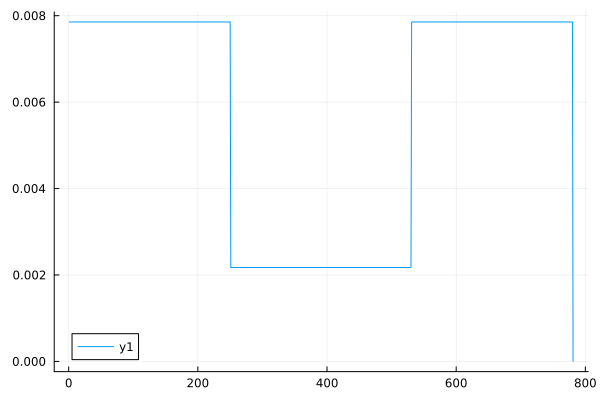

In [394]:
Plots.plot(dts)

In [395]:
duration = sum(dts) - dts[1] # in units of 1/E_R

T = length(dts)
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts;

In [396]:
times

781-element Vector{Float64}:
 0.0
 0.00580491344554764
 0.011609826891095281
 0.01741474033664292
 0.02321965378219056
 0.0290245672277382
 0.03482948067328584
 0.04063439411883348
 0.046439307564381124
 0.05224422100992877
 ⋮
 4.481393179962775
 4.487198093408322
 4.49300300685387
 4.498807920299418
 4.504612833744965
 4.510417747190513
 4.516222660636061
 4.5220275740816085
 4.5278324875271565

In [397]:
phi_bound = [1.0 * pi]

phi = angle.(a[1:1,:] + 1im*a[2:2,:])
phi_mod_clean!(phi)
acc = collect(times')

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×781 Matrix{Float64}:
 -3101.06  -3703.9  -4161.65  -7.48934  …  -3101.06  9918.87  0.0  0.0

In [398]:
acc

1×781 Matrix{Float64}:
 0.0  0.00580491  0.0116098  0.0174147  …  4.51042  4.51622  4.52203  4.52783

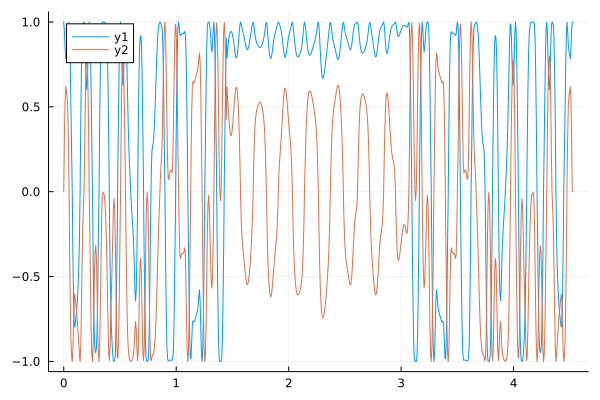

In [399]:
Plots.plot(times, a')

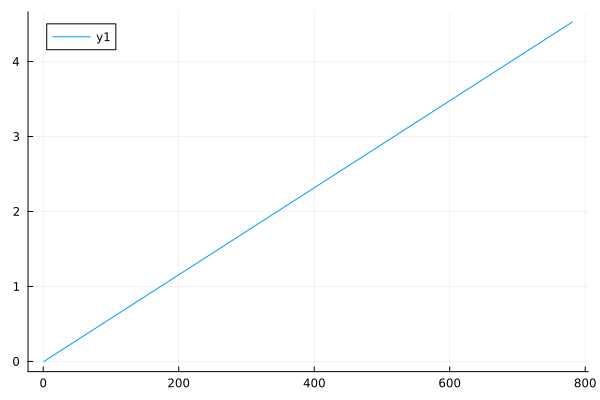

In [400]:
Plots.plot(times)

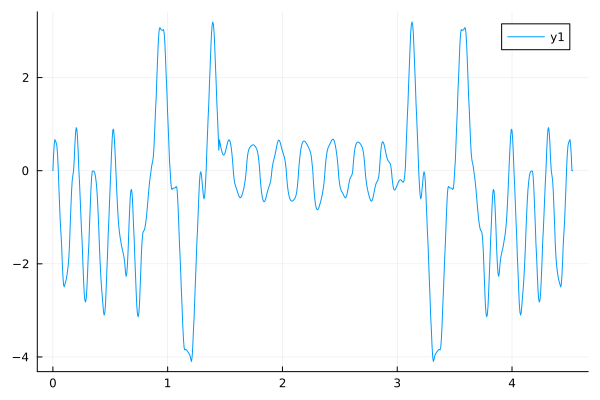

In [401]:
Plots.plot(times, phi')

In [403]:
# psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(0, dim)
if system.params[:accelerated]
    append!(psi0, zeros(dim))
end

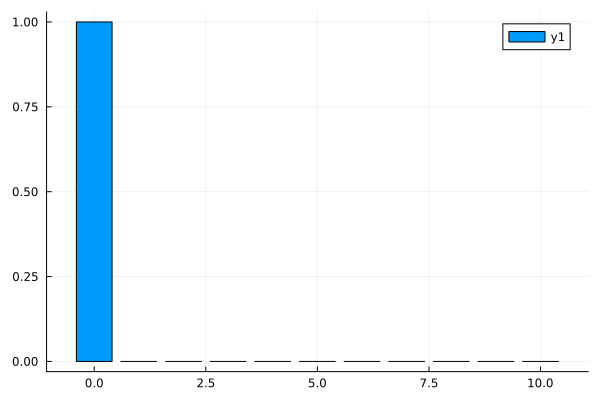

In [404]:
Plots.bar(0:dim-1, abs2.(psi0[1:dim]))

In [405]:
psi0_iso = QC.ket_to_iso(psi0)

22-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [407]:
time_flight = 2pi * 2.0
T_flight = Int(round(time_flight/2pi*2000; digits=0))

4000

In [408]:
#jumps = [(Z_split.T, time_flight), (Z_split.T+Z_mirror.T, time_flight)]
#jumps = [(div(T, 3), time_flight), (2*div(T, 3), time_flight)]
#jumps = [(div(T, 2), time_flight)]
jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, T_flight)

Matrix{Float64}[]

In [409]:
jumps

Tuple{Int64, Float64}[]

jumps = [(100, time_flight), (200, time_flight)]
#jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, 10000)

In [410]:
G

Matrix{Float64}[]

In [411]:
U = [QC.iso_vec_to_operator(QC.iso_operator_to_iso_vec(g)) for g in G]

Matrix{ComplexF64}[]

Plots.heatmap(sqrt.(abs.(U[1])), yflip=true)

Plots.heatmap(sqrt.(abs.(U[2])), yflip=true)

In [412]:
psi_iso = shaken_lattice_rollout(psi0_iso, a, dts, system, jumps, G)

22×781 Matrix{Float64}:
 1.0   0.999922      0.999696      0.999316     …  -0.56705     -0.561512
 0.0   9.49276e-21  -0.00577523   -0.0151833       -0.348885    -0.343864
 0.0  -2.58856e-19  -8.52818e-6   -5.4163e-5        0.189844     0.195075
 0.0   2.48248e-19  -0.0013455    -0.00352765       0.238541     0.227119
 0.0  -3.94604e-19   6.01617e-6    4.53778e-5       0.268863     0.293034
 0.0   9.32125e-20   8.80168e-5    0.000226765  …  -0.0275637   -0.0179025
 0.0  -3.55765e-20   2.82342e-6    1.97591e-5      -0.0900568   -0.105523
 0.0   1.53846e-22  -2.23204e-6   -5.4165e-6       -0.0416731   -0.0364815
 0.0   7.15288e-21   2.74631e-7    1.79765e-6       0.0489251    0.0530969
 0.0  -3.65876e-22  -2.76035e-8   -5.44756e-8       0.0180557   -0.0168388
 ⋮                                              ⋱                ⋮
 0.0  -2.57755e-17   0.000628318   0.00238572       0.163667     0.157395
 0.0   6.08777e-18   4.23621e-5    0.000241925     -0.110459    -0.132363
 0.0  -9.65448e-1

psi_iso = QC.rollout(psi0_iso, a, dts, system)#; integrator=exp)

In [413]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

11×781 Matrix{Float64}:
 1.0  1.0          0.999964     …  0.513939     0.514792    0.514792
 0.0  5.96262e-36  3.33555e-5      0.182468     0.181316    0.181316
 0.0  6.64444e-34  3.94856e-7      0.0633309    0.0628276   0.0628276
 0.0  3.71225e-35  1.81216e-6      0.0686324    0.0691031   0.0691031
 0.0  9.33646e-35  5.05922e-8      0.144801     0.145       0.145
 0.0  8.98449e-37  7.82837e-9   …  0.00262011   0.00265704  0.00265704
 0.0  1.30879e-37  2.38885e-10     0.0150097    0.0151392   0.0151392
 0.0  7.41323e-43  5.22938e-12     0.00179416   0.00177829  0.00177829
 0.0  1.6025e-39   2.6629e-13      0.00282657   0.00282153  0.00282153
 0.0  1.70455e-42  8.86673e-16     0.00371813   0.00371588  0.00371588
 0.0  2.34689e-43  2.4415e-16   …  0.000860617  0.0008491   0.0008491

In [419]:
relevant = [1,3,4]
pops_rel = pops[relevant,:]
pops_rest = 1 .- sum(pops_rel, dims=1)
pops_plot = vcat(pops_rel, pops_rest)

12×781 Matrix{Float64}:
 1.0  1.0          0.999964     0.99975      …  0.514792     0.514792
 0.0  5.96262e-36  3.33555e-5   0.000230544     0.181316     0.181316
 0.0  6.64444e-34  3.94856e-7   5.69457e-6      0.0628276    0.0628276
 0.0  3.71225e-35  1.81216e-6   1.25028e-5      0.0691031    0.0691031
 0.0  9.33646e-35  5.05922e-8   7.33488e-7      0.145        0.145
 0.0  8.98449e-37  7.82837e-9   5.3972e-8    …  0.00265704   0.00265704
 0.0  1.30879e-37  2.38885e-10  4.00624e-9      0.0151392    0.0151392
 0.0  7.41323e-43  5.22938e-12  3.78007e-11     0.00177829   0.00177829
 0.0  1.6025e-39   2.6629e-13   7.78019e-12     0.00282153   0.00282153
 0.0  1.70455e-42  8.86673e-16  7.68557e-15     0.00371588   0.00371588
 0.0  2.34689e-43  2.4415e-16   8.21827e-15  …  0.0008491    0.0008491
 0.0  4.44089e-16  9.99201e-16  8.88178e-16     8.99281e-15  9.21485e-15

In [420]:
acc

1×781 Matrix{Float64}:
 0.0  0.00580491  0.0116098  0.0174147  …  4.51042  4.51622  4.52203  4.52783

In [421]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    t_tick_step = 3.5
    current_tick_val = 0.
    shift = 0.
    xticks = Float64[]
    xticklabels = String[]
    for jump in jumps
        while current_tick_val < full_times[jump[1]]
            push!(xticks, current_tick_val-shift)
            push!(xticklabels, string(round(current_tick_val, digits=1)))
            current_tick_val += t_tick_step
        end
        while current_tick_val < full_times[jump[1]+1]
            current_tick_val += t_tick_step
        end
        shift += jump[2]
    end
    while current_tick_val < full_times[end]
        push!(xticks, current_tick_val-shift)
        push!(xticklabels, string(round(current_tick_val, digits=1)))
        current_tick_val += t_tick_step
    end

    #Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xticks!(p, (xticks, xticklabels))
    Plots.xlims!(p, (times[1], times[end]))
    Plots.ylims!(p, (0.0, 1.1))
    rel_y = 0.97
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end] - 0.03
        Plots.vline!(
            p, 
            [times[cut]], 
            color=:black,
            linewidth=1.1,
            label=nothing
            )
        Plots.annotate!(((rel_x, rel_y), (
            #string(round(jump_time; digits=1)), 
            L"4\pi",
            10,
            )))
    end
    Plots.xlabel!(p, L"Time $t ~ \left[\omega_R^{-1}\right]$")
    Plots.ylabel!(p, "Bloch state population")
    return p
end

format_plot (generic function with 4 methods)

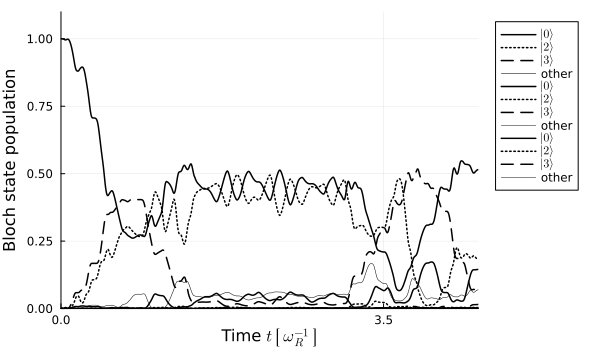

In [422]:
p = Plots.plot(
    times, 
    pops_plot', 
    labels=[L"|0\rangle" L"|2\rangle" L"|3\rangle" "other"], 
    legend=:outertopright, 
    size=(590,350), 
    c=:black,
    linestyle=[:solid :dot :dash :solid],
    alpha=[1. 1. 1. 1.],
    linewidth=[1.5 1.5 1.5 0.5]
    )
format_plot(p)

Plots.savefig(p, "patent_figs/bloch_MZ_3_full.pdf")

In [3]:
Z_split = NT.load_traj("interferometer/bloch_7_to_3.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor.jld2")

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.00012655239195148894 0.00012652806948185917 … -0.0005118537339097769 -0.001217494658182709; 0.003348732119556511 0.003348088517060973 … 0.00039202590761693804 -0.0014658894793041612; … ; -6.904280891876965 -13.631577279690154 … -511.882085937305 -511.882085937305; 0.00910606566257911 0.00910606566257911 … 0.00910606566257911 0.0], [0.00012655239195148894, 0.003348732119556511, 0.05097922316700025, 0.3668232006272215, 0.8518575330001765, 0.3668232006272226, 0.05097922316700042, 0.0033487321195565206, 0.00012655239195148916, -0.0  …  0.015364263671961101, -0.0016298251463880283, -0.000589567452136569, 1.0, 0.0, 0.0, 5.281289298477342e-15, -10.868438751197203, -511.882085937305, 0.0], 421, :dts, 25, (psi_iso = 18, a = 2, da = 2, dda = 2, dts = 1, states = 23, controls = 2), (a = ([-1.0, -1.0], [1.0, 1.0]), dts = ([0.00910606566257911], [0.00910606566257911])), (psi_iso = [0.00012655239195148894, 0.003348732119556511, 0.05

In [4]:
a, dts = get_interferometer(Z_split, Z_mirror, [])

([1.0 0.9446611218289769 … 1.0 1.0; 0.0 0.3280478088706261 … 0.0 0.0], [0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444  …  0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.00785398163397444, 0.0])

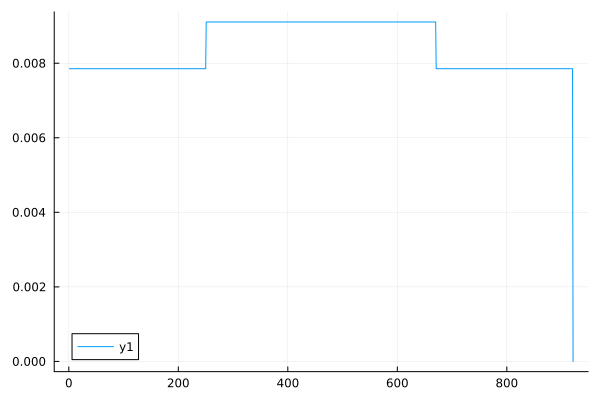

In [5]:
Plots.plot(dts)

In [6]:
duration = sum(dts) - dts[1] # in units of 1/E_R

T = length(dts)
# dt = duration / (T-1)
# dts = zeros(T) .+ dt
# dt_bound = (dt, dt)
times = cumsum(dts) - dts;

In [7]:
times

921-element Vector{Float64}:
 0.0
 0.00785398163397444
 0.015707963267948884
 0.023561944901923322
 0.03141592653589776
 0.0392699081698722
 0.04712388980384664
 0.05497787143782108
 0.06283185307179552
 0.07068583470576996
 ⋮
 7.6887065421986485
 7.6965605238326225
 7.704414505466597
 7.712268487100571
 7.720122468734546
 7.72797645036852
 7.735830432002495
 7.743684413636469
 7.751538395270444

In [8]:
phi_bound = [1.0 * pi]

phi = angle.(a[1:1,:] + 1im*a[2:2,:])
phi_mod_clean!(phi)
acc = collect(times')

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×921 Matrix{Float64}:
 -1694.03  -2023.35  -2273.41  -4.09124  …  -1694.03  5418.43  0.0  0.0

In [9]:
acc

1×921 Matrix{Float64}:
 0.0  0.00785398  0.015708  0.0235619  …  7.72798  7.73583  7.74368  7.75154

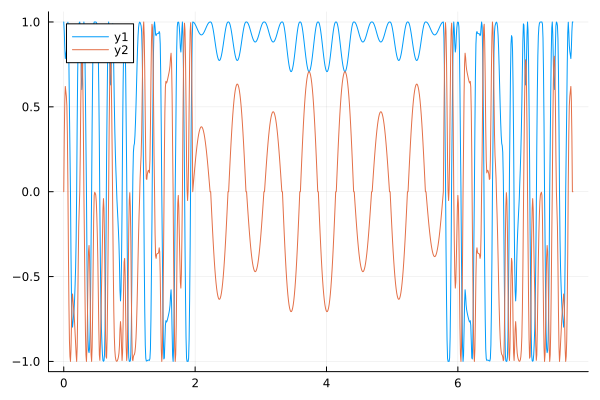

In [10]:
Plots.plot(times, a')

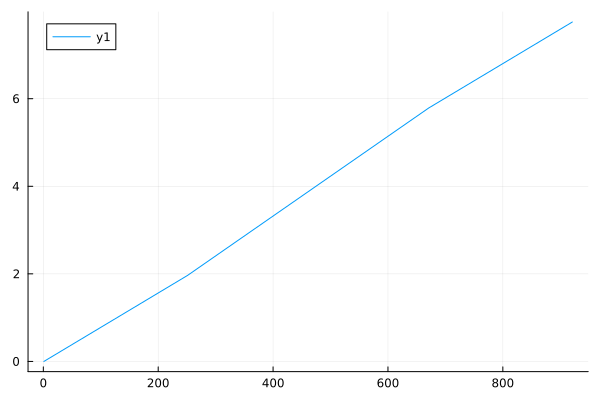

In [11]:
Plots.plot(times)

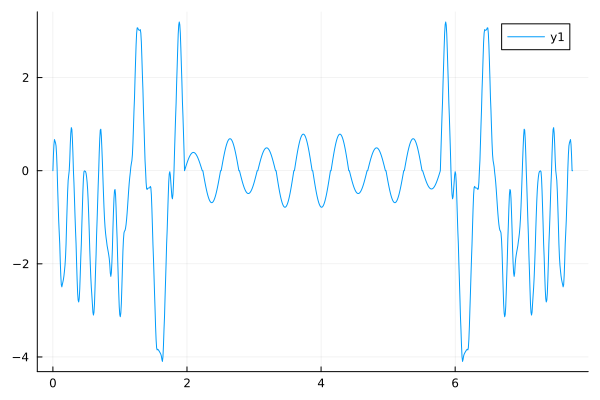

In [12]:
Plots.plot(times, phi')

In [28]:
# psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(7, dim)
if system.params[:accelerated]
    append!(psi0, zeros(dim))
end

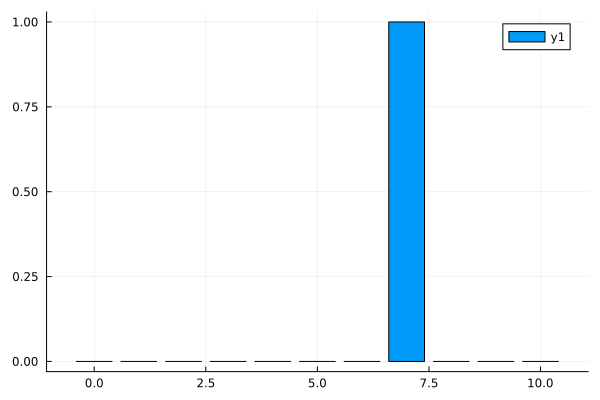

In [29]:
Plots.bar(0:dim-1, abs2.(psi0[1:dim]))

In [30]:
psi0_iso = QC.ket_to_iso(psi0)

22-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [34]:
jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, 2)

Matrix{Float64}[]

In [35]:
psi_iso = shaken_lattice_rollout(psi0_iso, a, dts, system, jumps, G)

22×921 Matrix{Float64}:
 0.0  -8.35543e-22   2.1163e-6     2.14444e-6   …   0.153503     0.153269
 0.0   8.66644e-20   1.6098e-8    -1.13783e-6      -0.0630739   -0.061058
 0.0   7.79021e-20  -1.13991e-5   -1.18553e-5      -0.0282021   -0.0285581
 0.0   8.39411e-19  -1.44289e-5   -8.26381e-5      -0.142605    -0.122054
 0.0  -1.1503e-18    0.000151525   0.000162817     -0.126995    -0.13644
 0.0  -2.667e-17     0.000846776   0.00399045   …  -0.0453727   -0.0551782
 0.0  -3.73858e-17   0.00401027    0.0042371       -0.0215907   -0.0177954
 1.0   0.87614       0.535257      0.061907         0.7327       0.928624
 0.0  -5.05242e-16  -4.14861e-11   8.49714e-8       0.0244601    0.014697
 0.0   6.25464e-18  -0.00125459   -0.0036845        0.0334272    0.057126
 ⋮                                              ⋱                ⋮
 0.0   2.77651e-19   1.24274e-5    4.28331e-5      -0.00869971  -0.00744838
 0.0   2.57522e-18  -4.08287e-5   -0.000170317      0.152925     0.16978
 0.0  -3.52746e-18

In [36]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

11×921 Matrix{Float64}:
 0.0  1.2054e-41   9.54879e-12  6.92887e-11  …  0.0237193    0.0237193
 0.0  1.09318e-37  1.02895e-11  2.80619e-10     0.00925461   0.00925461
 0.0  8.31588e-38  2.8438e-10   1.97522e-9      0.000871044  0.000871044
 0.0  7.33637e-36  1.87517e-9   3.5837e-8       0.0437224    0.0437224
 0.0  1.37661e-35  5.25164e-8   3.54969e-7      0.0229204    0.0229204
 0.0  4.84474e-33  1.17386e-6   1.67773e-5   …  0.00378389   0.00378389
 0.0  9.52001e-33  4.12221e-5   0.000281724     0.000576204  0.000576204
 1.0  1.0          0.999915     0.999406        0.890511     0.890511
 0.0  1.09851e-30  5.6759e-21   1.62712e-11     0.00079341   0.00079341
 0.0  1.08488e-34  1.60144e-6   1.89905e-5      0.00336066   0.00336066
 0.0  1.92868e-34  4.06496e-5   0.000276322  …  0.000486898  0.000486898

In [37]:
relevant = [3,4,6,8]
pops_rel = pops[relevant,:]
pops_rest = 1 .- sum(pops_rel, dims=1)
pops_plot = vcat(pops_rel, pops_rest)

5×921 Matrix{Float64}:
 0.0   8.31588e-38  2.8438e-10  1.97522e-9   …  0.000871044  0.000871044
 0.0   7.33637e-36  1.87517e-9  3.5837e-8       0.0437224    0.0437224
 0.0   4.84474e-33  1.17386e-6  1.67773e-5      0.00378389   0.00378389
 1.0   1.0          0.999915    0.999406        0.890511     0.890511
 0.0  -2.22045e-16  8.35256e-5  0.000577392     0.0611114    0.0611114

In [38]:
acc

1×921 Matrix{Float64}:
 0.0  0.00785398  0.015708  0.0235619  …  7.72798  7.73583  7.74368  7.75154

In [39]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    t_tick_step = 0.8
    current_tick_val = 0.
    shift = 0.
    xticks = Float64[]
    xticklabels = String[]
    for jump in jumps
        while current_tick_val < full_times[jump[1]]
            push!(xticks, current_tick_val-shift)
            push!(xticklabels, string(round(current_tick_val, digits=1)))
            current_tick_val += t_tick_step
        end
        while current_tick_val < full_times[jump[1]+1]
            current_tick_val += t_tick_step
        end
        shift += jump[2]
    end
    while current_tick_val < full_times[end]
        push!(xticks, current_tick_val-shift)
        push!(xticklabels, string(round(current_tick_val, digits=1)))
        current_tick_val += t_tick_step
    end

    #Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xticks!(p, (xticks, xticklabels))
    Plots.xlims!(p, (times[1], times[end]))
    Plots.ylims!(p, (0.0, 1.1))
    rel_y = 0.97
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end] - 0.03
        Plots.vline!(
            p, 
            [times[cut]], 
            color=:black,
            linewidth=1.1,
            label=nothing
            )
        Plots.annotate!(((rel_x, rel_y), (
            #string(round(jump_time; digits=1)), 
            L"4\pi",
            10,
            )))
    end
    Plots.xlabel!(p, L"Time $t ~ \left[\omega_R^{-1}\right]$")
    Plots.ylabel!(p, "Bloch state population")
    return p
end

format_plot (generic function with 4 methods)

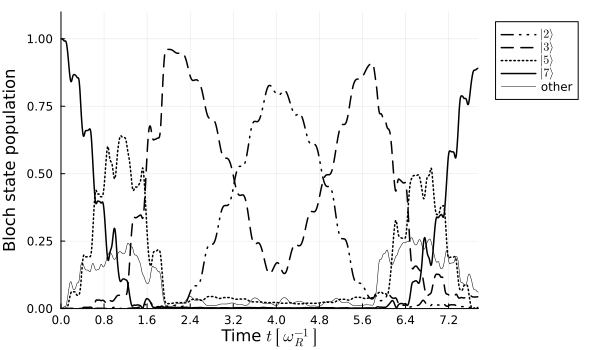

In [40]:
p = Plots.plot(
    times, 
    pops_plot', 
    labels=[L"|2\rangle" L"|3\rangle" L"|5\rangle" L"|7\rangle" "other"], 
    legend=:outertopright, 
    size=(590,350), 
    c=:black,
    linestyle=[:dashdotdot :dash :dot :solid :solid],
    linewidth=[1.5 1.5 1.5 1.5 0.5]
    )
format_plot(p)

In [41]:
Plots.savefig(p, "patent_figs/bloch_mirror_7_guess.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/patent_figs/bloch_mirror_7_guess.pdf"

In [42]:
Z = NT.load_traj("interferometer/mirror_bloch7.jld2")

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.0 7.579451050525458e-13 … 0.0010459929944465825 0.0010316613884548012; 0.0 8.387236817273379e-13 … -0.0015699506877752006 -0.0015652426060506605; … ; -747.4093761512822 -621.4779158940877 … 4.781560412385471 4.8279232535105745; 0.007853980828587442 0.007853980828587442 … 0.007853980828587442 0.007853980828587442], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0  …  -0.23801945801942426, -7.711299485466049e-5, 0.0022644497702749575, 1.0, 0.0, 1.0522502039989639, -16.297447774195916, -9.339429822087135e-14, 4.8279232535105745, 0.007853980828587442], 987, :dts, 51, (psi_iso = 22, v_iso = 22, a = 2, da = 2, dda = 2, dts = 1, states = 49, controls = 2), (a = ([-1.0, -1.0], [1.0, 1.0]), dda = ([-2000.0, -2000.0], [2000.0, 2000.0]), dts = ([0.007853980828587442], [0.007853980828587442])), (psi_iso = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], v_iso = [0.0, 0.0, 0.

In [43]:
a, dts = Z.a, vec(Z.dts)

([1.0 0.9874038485989711 … 0.9917360768312858 1.0; 0.0 0.1582202255676161 … 0.1282947929985137 0.0], [0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442  …  0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442, 0.007853980828587442])

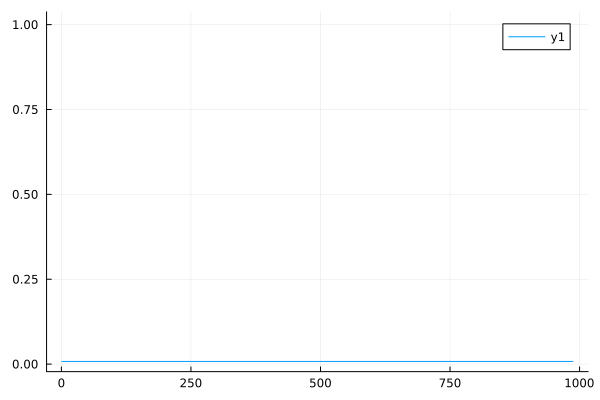

In [44]:
Plots.plot(dts)

In [45]:
duration = sum(dts) - dts[1] # in units of 1/E_R

T = length(dts)
# dt = duration / (T-1)
# dts = zeros(T) .+ dt
# dt_bound = (dt, dt)
times = cumsum(dts) - dts;

In [46]:
times

987-element Vector{Float64}:
 0.0
 0.007853980828587442
 0.015707961657174883
 0.023561942485762325
 0.03141592331434977
 0.03926990414293721
 0.04712388497152466
 0.0549778658001121
 0.06283184662869955
 0.07068582745728699
 ⋮
 7.68119325035853
 7.689047231187117
 7.696901212015705
 7.704755192844292
 7.712609173672879
 7.720463154501467
 7.728317135330054
 7.7361711161586415
 7.7440250969872295

In [47]:
phi_bound = [1.0 * pi]

phi = angle.(a[1:1,:] + 1im*a[2:2,:])
phi_mod_clean!(phi)
acc = collect(times')

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×987 Matrix{Float64}:
 -713.841  -604.67  -480.29  -569.515  …  -533.061  -726.177  2085.59  0.0

In [48]:
acc

1×987 Matrix{Float64}:
 0.0  0.00785398  0.015708  0.0235619  …  7.72046  7.72832  7.73617  7.74403

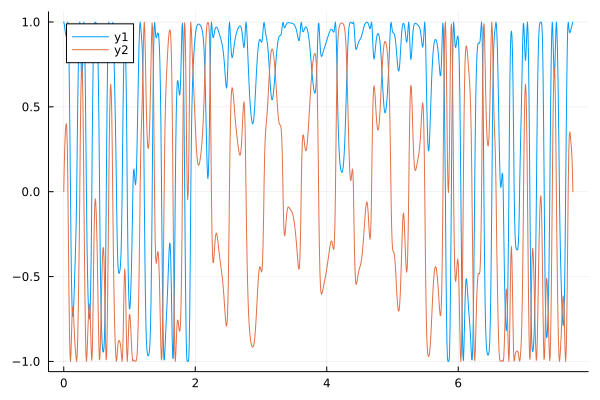

In [49]:
Plots.plot(times, a')

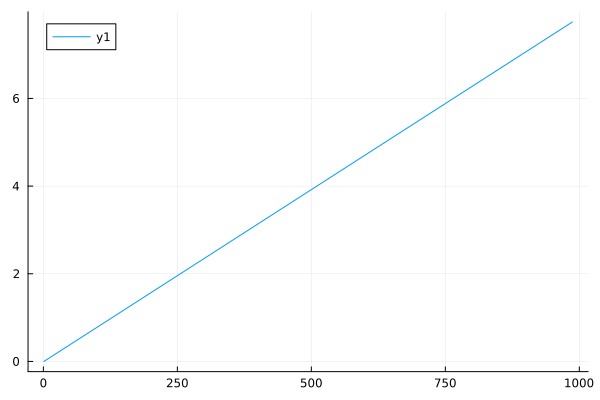

In [50]:
Plots.plot(times)

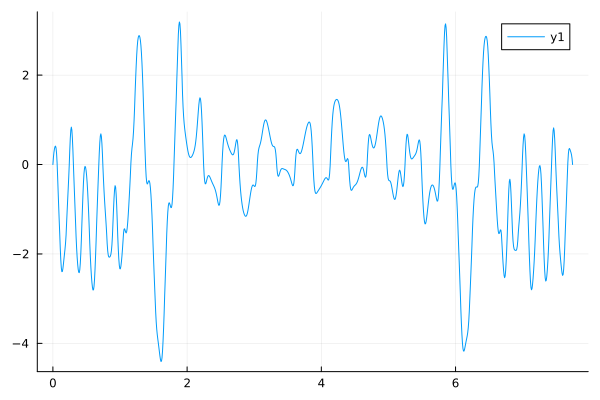

In [51]:
Plots.plot(times, phi')

In [53]:
# psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(7, dim)
if system.params[:accelerated]
    append!(psi0, zeros(dim))
end

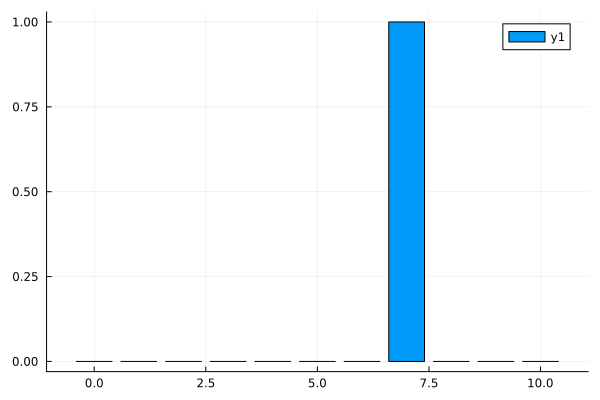

In [54]:
Plots.bar(0:dim-1, abs2.(psi0[1:dim]))

In [55]:
psi0_iso = QC.ket_to_iso(psi0)

22-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [57]:
jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, 2)

Matrix{Float64}[]

In [58]:
psi_iso = shaken_lattice_rollout(psi0_iso, a, dts, system, jumps, G)

22×987 Matrix{Float64}:
 0.0  -8.35543e-22   1.07055e-6    1.70064e-6   …   0.00104863    0.0010307
 0.0   8.66644e-20   2.30219e-8   -6.04571e-8      -0.00154602   -0.00154745
 0.0   7.79021e-20  -5.71492e-6   -8.6233e-6       -0.000192268  -0.000220226
 0.0   8.39411e-19  -3.14235e-6   -1.87036e-5      -0.000676453  -0.000532672
 0.0  -1.1503e-18    7.49458e-5    0.000103769     -0.000712484  -0.000738941
 0.0  -2.667e-17     0.000192737   0.000946721  …  -0.00135801   -0.00103136
 0.0  -3.73858e-17   0.00193411    0.00208428      -0.000939035   0.000611603
 1.0   0.87614       0.535246      0.0617915        0.661125      0.940908
 0.0  -5.05242e-16  -1.95473e-11   9.886e-9         0.000570317   0.000761236
 0.0   6.25463e-18  -0.000355347  -0.000793175     -0.000709144   0.000153608
 ⋮                                              ⋱   ⋮            
 0.0   2.77651e-19   5.74945e-6    1.97032e-5      -0.000476571  -0.000473487
 0.0   2.57522e-18  -9.44294e-6   -4.29936e-5       0.00108

In [59]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

11×987 Matrix{Float64}:
 0.0  1.2054e-41   2.19036e-12  …  1.78156e-6  1.77069e-6  1.76503e-6
 0.0  1.09318e-37  5.52879e-13     2.3773e-6   2.39687e-6  2.40904e-6
 0.0  8.31587e-38  6.57164e-11     2.48922e-7  2.64087e-7  2.72689e-7
 0.0  7.33637e-36  9.90435e-11     1.7094e-6   1.64029e-6  1.61425e-6
 0.0  1.37661e-35  1.22013e-8      1.70107e-6  1.33589e-6  1.14067e-6
 0.0  4.84474e-33  6.08198e-8   …  1.97716e-6  3.39037e-6  4.00971e-6
 0.0  9.52001e-33  9.58946e-6      4.73615e-5  7.94808e-6  1.78665e-6
 1.0  1.0          0.999981        0.999896    0.999973    0.999985
 0.0  1.09851e-30  1.31614e-21     6.25665e-7  6.25015e-7  6.24516e-7
 0.0  1.08488e-34  1.63301e-7      3.88905e-6  2.05091e-6  1.39471e-6
 0.0  1.92867e-34  9.45396e-6   …  4.22873e-5  5.80762e-6  2.51774e-7

In [60]:
relevant = [3,4,6,8]
pops_rel = pops[relevant,:]
pops_rest = 1 .- sum(pops_rel, dims=1)
pops_plot = vcat(pops_rel, pops_rest)

5×987 Matrix{Float64}:
 0.0   8.31587e-38  6.57164e-11  …  2.48922e-7   2.64087e-7  2.72689e-7
 0.0   7.33637e-36  9.90435e-11     1.7094e-6    1.64029e-6  1.61425e-6
 0.0   4.84474e-33  6.08198e-8      1.97716e-6   3.39037e-6  4.00971e-6
 1.0   1.0          0.999981        0.999896     0.999973    0.999985
 0.0  -2.22045e-16  1.92189e-5      0.000100023  2.19351e-5  9.37238e-6

In [61]:
acc

1×987 Matrix{Float64}:
 0.0  0.00785398  0.015708  0.0235619  …  7.72046  7.72832  7.73617  7.74403

In [62]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    t_tick_step = 0.8
    current_tick_val = 0.
    shift = 0.
    xticks = Float64[]
    xticklabels = String[]
    for jump in jumps
        while current_tick_val < full_times[jump[1]]
            push!(xticks, current_tick_val-shift)
            push!(xticklabels, string(round(current_tick_val, digits=1)))
            current_tick_val += t_tick_step
        end
        while current_tick_val < full_times[jump[1]+1]
            current_tick_val += t_tick_step
        end
        shift += jump[2]
    end
    while current_tick_val < full_times[end]
        push!(xticks, current_tick_val-shift)
        push!(xticklabels, string(round(current_tick_val, digits=1)))
        current_tick_val += t_tick_step
    end

    #Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xticks!(p, (xticks, xticklabels))
    Plots.xlims!(p, (times[1], times[end]))
    Plots.ylims!(p, (0.0, 1.1))
    rel_y = 0.97
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end] - 0.03
        Plots.vline!(
            p, 
            [times[cut]], 
            color=:black,
            linewidth=1.1,
            label=nothing
            )
        Plots.annotate!(((rel_x, rel_y), (
            #string(round(jump_time; digits=1)), 
            L"4\pi",
            10,
            )))
    end
    Plots.xlabel!(p, L"Time $t ~ \left[\omega_R^{-1}\right]$")
    Plots.ylabel!(p, "Bloch state population")
    return p
end

format_plot (generic function with 4 methods)

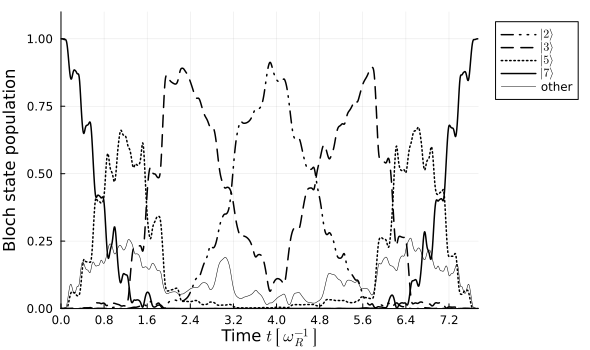

In [63]:
p = Plots.plot(
    times, 
    pops_plot', 
    labels=[L"|2\rangle" L"|3\rangle" L"|5\rangle" L"|7\rangle" "other"], 
    legend=:outertopright, 
    size=(590,350), 
    c=:black,
    linestyle=[:dashdotdot :dash :dot :solid :solid],
    linewidth=[1.5 1.5 1.5 1.5 0.5]
    )
format_plot(p)

In [64]:
Plots.savefig(p, "patent_figs/bloch_mirror_7_opt.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/patent_figs/bloch_mirror_7_opt.pdf"

In [65]:
import DataFrames as DF
import CSV

In [67]:
df = CSV.read("interferometer/mirror_7_constraint_opt.csv", DF.DataFrame, header=[1,2])

5934×8 DataFrame
  Row │ B2_X         Column2_Y          B3_X         Column4_Y        B6_X     ⋯
      │ Float64?     Float64?           Float64?     Float64?         Float64  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │       0.435        0.000547965        0.342        0.0101653    0.078  ⋯
    2 │       0.436        0.000547965        0.343        0.0101653    0.079
    3 │       0.437        0.000547965        0.344        0.0101653    0.08
    4 │       0.438        0.000547965        0.345        0.0101653    0.081
    5 │       0.439        0.000547965        0.346        0.0101653    0.082  ⋯
    6 │       0.44         0.000547965        0.347        0.0101653    0.083
    7 │       0.441        0.000547965        0.348        0.0101653    0.084
    8 │       0.442        0.000547965        0.357        0.0120888    0.085
  ⋮   │      ⋮               ⋮               ⋮              ⋮            ⋮     ⋱
 5928 │ missing      missing            missing      missing            6.212  ⋯
 5929 │ missing      missing            missing      missing            6.213
 5930 │ missing      missing            missing      missing            6.214
 5931 │ missing      missing            missing      missing            6.215
 5932 │ missing      missing            missing      missing            6.216  ⋯
 5933 │ missing      missing            missing      missing            6.217
 5934 │ missing      missing            missing      missing            6.218
                                                 3 columns and 5919 rows omitted

In [68]:
time_step = 0.01
times = collect(0.:time_step:2pi)


629-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 6.2
 6.21
 6.22
 6.23
 6.24
 6.25
 6.26
 6.2700000000000005
 6.28

In [69]:
nrows, ncols = size(df)

(5934, 8)

In [70]:
pops = zeros(4, length(times))

4×629 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [71]:
for k=1:4
    times_pops = filter(x -> (!ismissing(x[1]) && (0 <= x[1] <= 2pi) && (0 <= x[2] <= 1.0)), collect(zip(df[:,2k-1], df[:,2k])))
    if k == 4
        times_pops = vcat((0.0, 1.0), times_pops, (2pi, 1.0))
    else
        times_pops = vcat((0.0, 0.0), times_pops, (2pi, 0.0))
    end

    for i=1:(length(times_pops)-1)
        (time, pop) = times_pops[i]
        (time_next, pop_next) = times_pops[i+1]
        idx = Int(round(time/time_step, digits=0)) + 1
        pops[k,idx] = pop

        # interpolation
        idx_next = Int(round(time_next/time_step, digits=0)) + 1
        steps = idx_next - idx
        pop_step = (pop_next - pop)/steps
        for j=1:(steps-1)
            pops[k,idx+j] = pop + j*pop_step
        end
    end
end
pops[end,end] = 1.0

1.0

In [72]:
pops_rest = 1 .- sum(pops, dims=1)

1×629 Matrix{Float64}:
 0.000206886  -0.00257739  -0.00439992  …  -0.00493901  -0.00380867  0.0

In [73]:
l = size(pops_rest, 2)

629

In [74]:
N = 2
d = Dict(i => ones(l-abs(i))/(2N+1) for i=-N:N)
M = LA.diagm(d...)

629×629 Matrix{Float64}:
 0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2  0.2  0.2  0.2  0.2  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.2  0.2  0.2  0.2  0.2  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.2  0.2  0.2  0.2  0.2  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.2  0.2  0.2  0.2  0.2  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.2  0.2  0.2  0.2     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.2  0.2  0.2     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.2  0.2     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                 ⋮              
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.2  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

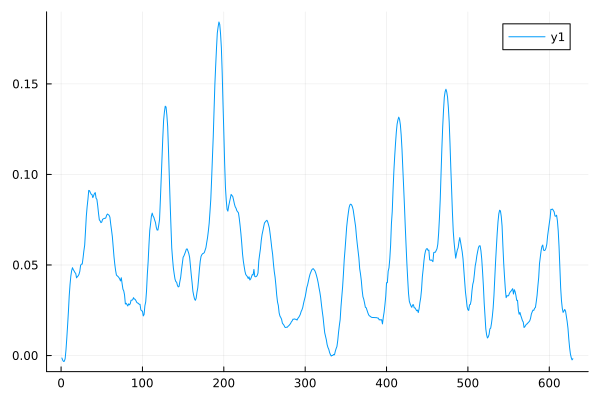

In [75]:
Plots.plot(M*pops_rest')

In [76]:
pops = vcat(pops, pops_rest*M)

5×629 Matrix{Float64}:
  0.0          1.24538e-5    2.49075e-5   …   3.4809e-5     0.0
  0.0          0.000298981   0.000597961      0.000363048   0.0
  0.0          0.00247284    0.00494568       0.0036177     0.0
  0.999793     0.999793      0.998831         0.999793      1.0
 -0.00135408  -0.00259858   -0.00324584      -0.00238636   -0.00174954

In [78]:
full_times = times
jumps = Tuple{Int64, Float64}[]

Tuple{Int64, Float64}[]

In [79]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    t_tick_step = 0.8
    current_tick_val = 0.
    shift = 0.
    xticks = Float64[]
    xticklabels = String[]
    for jump in jumps
        while current_tick_val < full_times[jump[1]]
            push!(xticks, current_tick_val-shift)
            push!(xticklabels, string(round(current_tick_val, digits=1)))
            current_tick_val += t_tick_step
        end
        while current_tick_val < full_times[jump[1]+1]
            current_tick_val += t_tick_step
        end
        shift += jump[2]
    end
    while current_tick_val < full_times[end]
        push!(xticks, current_tick_val-shift)
        push!(xticklabels, string(round(current_tick_val, digits=1)))
        current_tick_val += t_tick_step
    end

    #Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xticks!(p, (xticks, xticklabels))
    Plots.xlims!(p, (times[1], times[end]))
    Plots.ylims!(p, (0.0, 1.1))
    rel_y = 0.97
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end] - 0.03
        Plots.vline!(
            p, 
            [times[cut]], 
            color=:black,
            linewidth=1.1,
            label=nothing
            )
        Plots.annotate!(((rel_x, rel_y), (
            #string(round(jump_time; digits=1)), 
            L"4\pi",
            10,
            )))
    end
    Plots.xlabel!(p, L"Time $t ~ \left[\omega_R^{-1}\right]$")
    Plots.ylabel!(p, "Bloch state population")
    return p
end

format_plot (generic function with 4 methods)

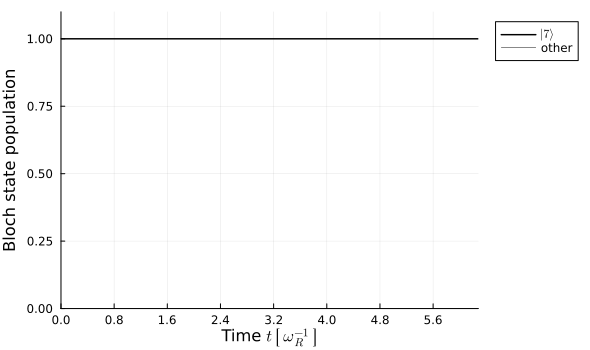

In [84]:
p = Plots.plot(
    times, 
    #pops',
    hcat(ones(length(times)), zeros(length(times))),
    #labels=[L"|2\rangle" L"|3\rangle" L"|6\rangle" L"|7\rangle" "other"], 
    labels=[L"|7\rangle" "other"], 
    legend=:outertopright, 
    size=(590,350), 
    c=:black,
    # linestyle=[:dashdotdot :dash :dot :solid :solid],
    # linewidth=[1.5 1.5 1.5 1.5 0.5]
    linestyle=[:solid :solid],
    linewidth=[1.5 0.5]
    )
format_plot(p)

p = Plots.plot(
    times, 
    vcat(zeros(3, length(times)), ones(1, length(times)), zeros(1, length(times)))',
    labels=[L"|3\rangle" L"|4\rangle" L"|6\rangle" L"|7\rangle" "other"], 
    legend=:outertopright, 
    size=(590,350), 
    c=:black,
    linestyle=[:dashdotdot :dash :dot :solid :solid],
    linewidth=[1.5 1.5 1.5 1.5 0.5]
    )
format_plot(p)

In [85]:
Plots.savefig(p, "patent_figs/bloch_mirror_7_opt_naive.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/patent_figs/bloch_mirror_7_opt_naive.pdf"

# Bloch state plot

In [79]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(
    V, 
    trunc; 
    acc=0.0, 
    bloch_basis=true,
    bloch_transformation_trunc=2*trunc,
    include_acc_derivative=false, 
    sparse=false)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
B = system.params[:bloch_states][:,1:trunc]
if system.params[:accelerated]
    B2 = blockdiagonal(B, B)
end

In [81]:
B_max = 9

9

In [82]:
n_max = 4
mid = div(size(B, 1)+1, 2)
ticks = 2*(-n_max:n_max)
slice = (-n_max:n_max) .+ mid

8:16

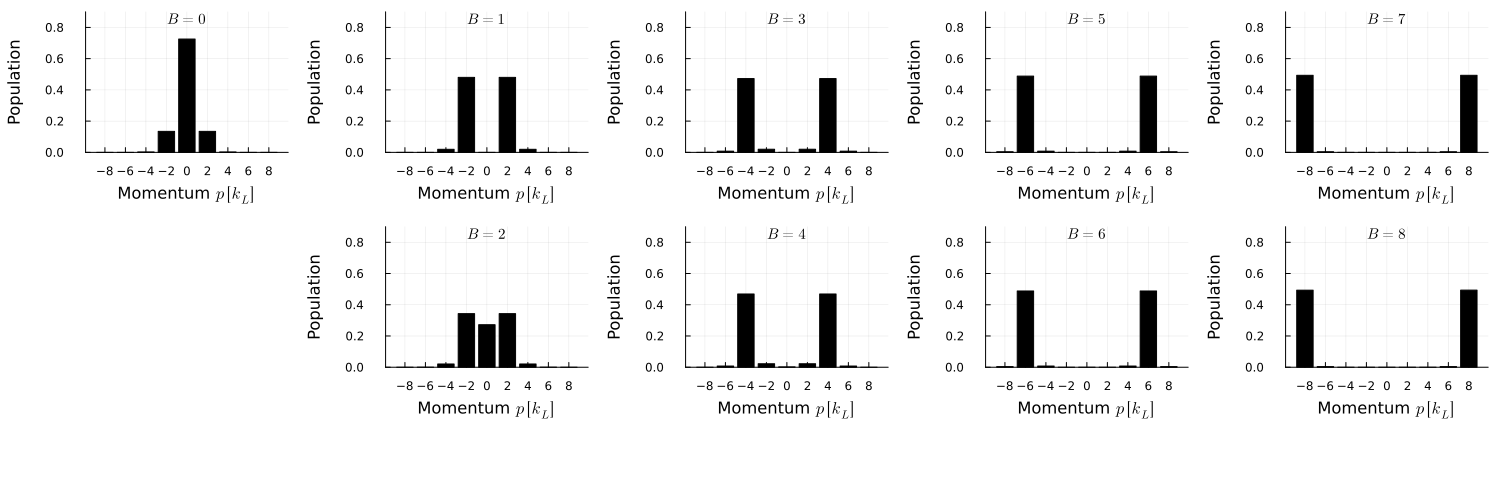

In [187]:
layout = Plots.@layout [
    x{0.4h} x x x x; _ x{0.4h} x x x # Plots.grid(2, div(B_max-1, 2))
]
is = reshape(collect(2:B_max), 2, div(B_max-1, 2))
is = transpose(is)
is = vcat(1, vec(is))
ps = [Plots.bar(
    ticks, 
    abs2.(B[slice,is[i]]), 
    ylim=(0.0, 0.9), 
    xticks=ticks,
    color=:black,
    xlabel=L"Momentum $p ~ [k_L]$",
    ylabel="Population",
    left_margin=2.0*Plots.mm,
    bottom_margin=8.0*Plots.mm,
    label=nothing) for i=1:B_max]
for (i, p) in enumerate(ps)
    Plots.annotate!(p, ((0.5, 0.95), (L"B=%$(is[i]-1)", 10, :black)))
end
q = Plots.plot(ps..., layout=layout, size=(1500, 500), left_margin=8*Plots.mm)


In [188]:
Plots.savefig(q, "patent_figs/Bloch_states.pdf")

"/local/lmseifert/Infleqtion/research-superstaq/research_superstaq/theory/shaken_lattice/Max_QC/Bloch_states.pdf"

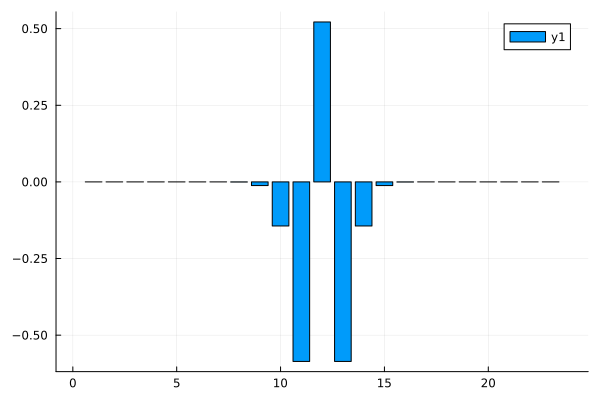

In [196]:
Plots.bar(real.(B[:,3]))